In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from torch import nn

# Loading CSV data

In [2]:
data = pd.read_csv('../input/age-gender-and-ethnicity-face-data-csv/age_gender.csv')

## Converting pixels into numpy array
data['pixels']=data['pixels'].apply(lambda x:  np.array(x.split(), dtype="float32"))

data.head()

age  ethnicity  gender                        img_name  \
0    1          2       0  20161219203650636.jpg.chip.jpg   
1    1          2       0  20161219222752047.jpg.chip.jpg   
2    1          2       0  20161219222832191.jpg.chip.jpg   
3    1          2       0  20161220144911423.jpg.chip.jpg   
4    1          2       0  20161220144914327.jpg.chip.jpg   

                                              pixels  
0  [129.0, 128.0, 128.0, 126.0, 127.0, 130.0, 133...  
1  [164.0, 74.0, 111.0, 168.0, 169.0, 171.0, 175....  
2  [67.0, 70.0, 71.0, 70.0, 69.0, 67.0, 70.0, 79....  
3  [193.0, 197.0, 198.0, 200.0, 199.0, 200.0, 202...  
4  [202.0, 205.0, 209.0, 210.0, 209.0, 209.0, 210...

### Shuffling data

In [3]:
data = data.sample(frac=1)

### Splitting train and eval dataframe

In [4]:
train_dataframe = data[:int(0.8*len(data))]
eval_dataframe = data[int(0.8*len(data)):]

# Creating a Custom Dataset with Pytorch

In [5]:
class MyDataset(Dataset):
    
    def __init__(self, dataframe):
        
        self.dataframe = dataframe
        self.transform = transforms.Compose([transforms.ToTensor()])
        
    def __len__(self):
        return len(self.dataframe)
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
            
        age = self.dataframe['age'].iloc[idx]
        ethnicity = self.dataframe['ethnicity'].iloc[idx]
        gender = self.dataframe['gender'].iloc[idx]
        
        pixels = self.dataframe['pixels'].iloc[idx]
        pixels = np.array(pixels.tolist())
        pixels = pixels.reshape(48,48)/255
        pixels = np.array(pixels, 'float32')
        
        pixels = self.transform(pixels)
        
        sample = {'image': pixels, 'age': age, 'ethnicity': ethnicity, 'gender':gender}
        
        return sample

In [6]:
train_dataset = MyDataset(train_dataframe)
eval_dataset = MyDataset(eval_dataframe)

### Creating DataLoader

In [7]:
batch_size=100

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
eval_dataloader = DataLoader(eval_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

# Creating the VAE Model

In [8]:
class VAEmodel(nn.Module):
    def __init__(self, latent_dims, hidden_dims, image_shape):
        super(VAEmodel, self).__init__()
        
        self.latent_dims = latent_dims #Size of the latent space layer
        self.hidden_dims = hidden_dims #List of hidden layers number of filters/channels
        self.image_shape = image_shape #Input image shape
        
        self.last_channels = self.hidden_dims[-1]
        self.in_channels = self.image_shape[0]
        #Simple formula to get the number of neurons after the last convolution layer is flattened
        self.flattened_channels = int(self.last_channels*(self.image_shape[1]/(2**len(self.hidden_dims)))**2) 
       
        # For each hidden layer we will create a Convolution Block
        modules = []
        for h_dim in self.hidden_dims:
            modules.append(
                nn.Sequential(
                    nn.Conv2d(in_channels=self.in_channels,
                              out_channels=h_dim,
                              kernel_size=3,
                              stride=2,
                              padding=1),
                    nn.BatchNorm2d(h_dim),
                    nn.LeakyReLU()
                )
            )
            
            self.in_channels = h_dim
        
        self.encoder = nn.Sequential(*modules)
        
        # Here are our layers for our latent space distribution
        self.fc_mu = nn.Linear(self.flattened_channels, latent_dims)
        self.fc_var = nn.Linear(self.flattened_channels, latent_dims)
        
        # Decoder input layer
        self.decoder_input = nn.Linear(latent_dims, self.flattened_channels)
        
        # For each Convolution Block created on the Encoder we will do a symmetric Decoder with the same Blocks, but using ConvTranspose
        self.hidden_dims.reverse()
        modules = []
        for h_dim in self.hidden_dims:
            modules.append(
                nn.Sequential(
                    nn.ConvTranspose2d(in_channels=self.in_channels,
                                       out_channels=h_dim,
                                       kernel_size=3,
                                       stride=2,
                                       padding=1,
                                       output_padding=1),
                    nn.BatchNorm2d(h_dim),
                    nn.LeakyReLU()
                )
            )
            
            self.in_channels = h_dim
        
        self.decoder = nn.Sequential(*modules)
        
        # The final layer the reconstructed image have the same dimensions as the input image
        self.final_layer = nn.Sequential(
            nn.Conv2d(in_channels=self.in_channels,
                      out_channels=self.image_shape[0],
                      kernel_size=3,
                      padding=1),
            nn.Sigmoid()
        )
        
    def get_latent_dims(self):
        
        return self.latent_dims
        
    def encode(self, input):
        """
        Encodes the input by passing through the encoder network
        and returns the latent codes.
        """
        result = self.encoder(input)
        result = torch.flatten(result, start_dim=1)
        # Split the result into mu and var componentsbof the latent Gaussian distribution
        mu = self.fc_mu(result)
        log_var = self.fc_var(result)
        
        return [mu, log_var]
    
    def decode(self, z):
        """
        Maps the given latent codes onto the image space.
        """
        result = self.decoder_input(z)
        result = result.view(-1, self.last_channels, int(self.image_shape[1]/(2**len(self.hidden_dims))), int(self.image_shape[1]/(2**len(self.hidden_dims))))
        result = self.decoder(result)
        result = self.final_layer(result)
        
        return result
    
    def reparameterize(self, mu, log_var):
        """
        Reparameterization trick to sample from N(mu, var) from N(0,1).
        """
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        
        return mu + eps * std
    
    def forward(self, input):
        """
        Forward method which will encode and decode our image.
        """
        mu, log_var = self.encode(input)
        z = self.reparameterize(mu, log_var)
        
        return  [self.decode(z), input, mu, log_var, z]
    
    def loss_function(self, recons, input, mu, log_var):
        """
        Computes VAE loss function
        """
        recons_loss = nn.functional.binary_cross_entropy(recons.reshape(recons.shape[0],-1),
                                                         input.reshape(input.shape[0],-1),
                                                         reduction="none").sum(dim=-1)
       
        kld_loss = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp(), dim=-1)
        
        loss = (recons_loss + kld_loss).mean(dim=0)
        
        return loss
        
    def sample(self, num_samples, device):
        """
        Samples from the latent space and return the corresponding
        image space map.
        """
        z = torch.randn(num_samples, self.latent_dims)
        z = z.to(device)
        samples = self.decode(z)
        
        return samples
    
    def generate(self, x):
        """
        Given an input image x, returns the reconstructed image
        """
        return self.forward(x)[0]
    
    def interpolate(self, starting_inputs, ending_inputs, device, granularity=10):
        """This function performs a linear interpolation in the latent space of the autoencoder
        from starting inputs to ending inputs. It returns the interpolation trajectories.
        """
        mu, log_var = self.encode(starting_inputs.to(device))
        starting_z = self.reparameterize(mu, log_var)
        
        mu, log_var = self.encode(ending_inputs.to(device))
        ending_z  = self.reparameterize(mu, log_var)
        
        t = torch.linspace(0, 1, granularity).to(device)
        
        intep_line = (
            
            torch.kron(starting_z.reshape(starting_z.shape[0], -1), (1 - t).unsqueeze(-1))+
            torch.kron(ending_z.reshape(ending_z.shape[0], -1), t.unsqueeze(-1))
            
        )
    
        decoded_line = self.decode(intep_line).reshape(
            (
                starting_inputs.shape[0],
                t.shape[0]
            )
            + (starting_inputs.shape[1:])
        )
        return decoded_line

### Instantiate the VAE Model

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

VAE = VAEmodel(latent_dims=20, hidden_dims=[32, 64, 64], image_shape=[1,48,48])

print(VAE)

VAEmodel(
  (encoder): Sequential(
    (0): Sequential(
      (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
    )
    (1): Sequential(
      (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
    )
    (2): Sequential(
      (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
    )
  )
  (fc_mu): Linear(in_features=2304, out_features=20, bias=True)
  (fc_var): Linear(in_features=2304, out_features=20, bias=True)
  (decoder_input): Linear(in_features=20, out_features=2304, bias=True)
  (decoder): Sequential(
    (0): Sequential(
    

# Training

In [10]:
def plot_reconstruction(img, recons):
    """
    Plot the original and reconstructed images during training
    """
    fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(10, 5))

    for j in range(5):
        axes[0][j].imshow(np.squeeze(img[j].detach().cpu().numpy()), cmap='gray')
        axes[0][j].axis('off')

    for j in range(5):
        axes[1][j].imshow(np.squeeze(recons[j].detach().cpu().numpy()), cmap='gray')
        axes[1][j].axis('off')

    plt.tight_layout(pad=0.)
    plt.show()

Epoch: 1         Loss: 1400.7300
Epoch: 2         Loss: 1408.9946
Epoch: 3         Loss: 1412.0516
Epoch: 4         Loss: 1393.2830
Epoch: 5         Loss: 1405.5627
Epoch: 6         Loss: 1378.4508
Epoch: 7         Loss: 1401.0714
Epoch: 8         Loss: 1398.5422
Epoch: 9         Loss: 1397.0701
Epoch: 10         Loss: 1387.4407


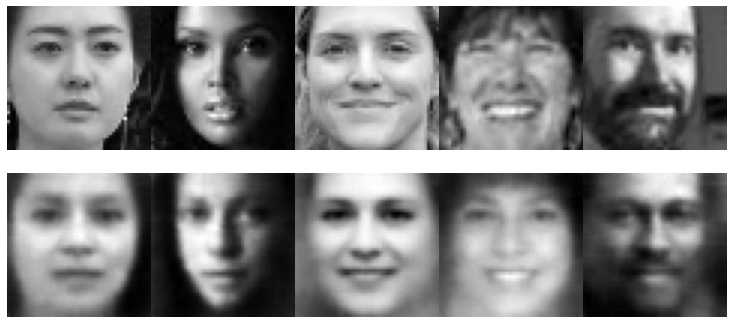

Epoch: 11         Loss: 1407.0146
Epoch: 12         Loss: 1401.1765
Epoch: 13         Loss: 1415.3109
Epoch: 14         Loss: 1446.1519
Epoch: 15         Loss: 1380.8116
Epoch: 16         Loss: 1410.7566
Epoch: 17         Loss: 1389.2814
Epoch: 18         Loss: 1368.7894
Epoch: 19         Loss: 1392.9409
Epoch: 20         Loss: 1410.0326


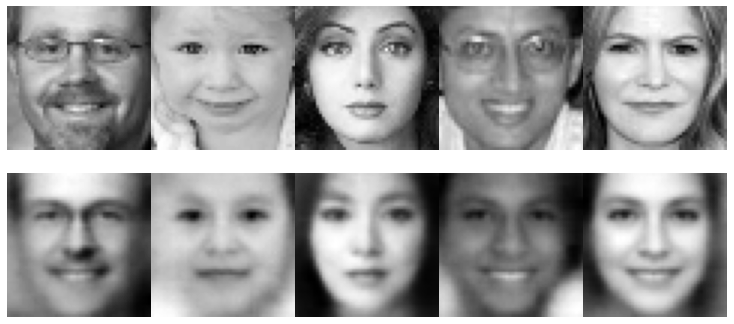

Epoch: 21         Loss: 1392.7400
Epoch: 22         Loss: 1420.5463
Epoch: 23         Loss: 1392.6638
Epoch: 24         Loss: 1370.0585
Epoch: 25         Loss: 1405.4117
Epoch: 26         Loss: 1375.0679
Epoch: 27         Loss: 1397.2979
Epoch: 28         Loss: 1382.2729
Epoch: 29         Loss: 1411.3655
Epoch: 30         Loss: 1368.0046


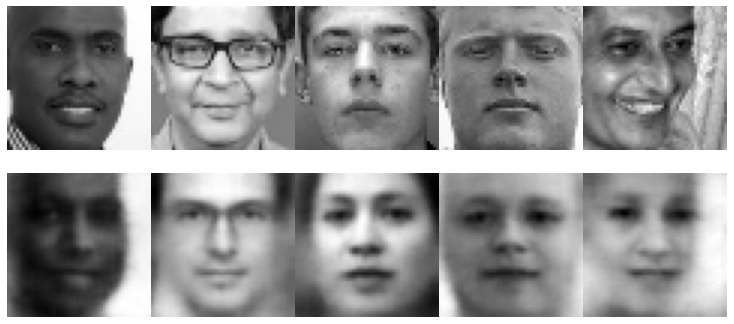

Epoch: 31         Loss: 1388.6890
Epoch: 32         Loss: 1399.6282
Epoch: 33         Loss: 1402.6826
Epoch: 34         Loss: 1413.0381
Epoch: 35         Loss: 1403.3586
Epoch: 36         Loss: 1409.5792
Epoch: 37         Loss: 1398.0786
Epoch: 38         Loss: 1388.1793
Epoch: 39         Loss: 1389.2900
Epoch: 40         Loss: 1438.7378


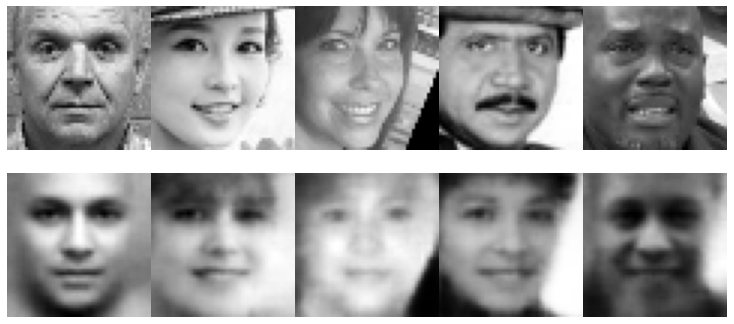

Epoch: 41         Loss: 1402.0662
Epoch: 42         Loss: 1355.0222
Epoch: 43         Loss: 1388.2871
Epoch: 44         Loss: 1396.8220
Epoch: 45         Loss: 1417.4850
Epoch: 46         Loss: 1384.5511
Epoch: 47         Loss: 1400.5774
Epoch: 48         Loss: 1410.9971
Epoch: 49         Loss: 1406.7600
Epoch: 50         Loss: 1385.0944


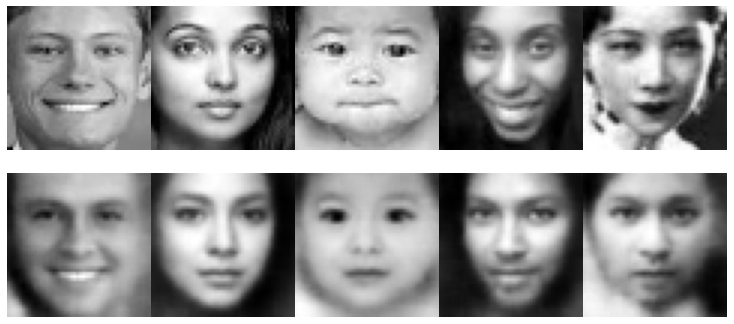

In [11]:
VAE = VAE.to(device)
VAE.train()

epochs = 50

optimizer = torch.optim.Adam(VAE.parameters(), lr=1e-3)

for epoch in range(epochs):
    
    for batch in train_dataloader:
        
        img = batch['image'].to(device)
        
        optimizer.zero_grad()
        
        recons, input, mu, log_var, _ = VAE.forward(img)
        
        loss = VAE.loss_function(recons, input, mu, log_var)
        
        loss.backward()
        
        optimizer.step()
        
    print(f"Epoch: {epoch+1}         Loss: {loss:.4f}")
    if (epoch+1)%10==0:
        plot_reconstruction(img, recons)

# Sampling from latent space

In [12]:
VAE.eval()
samples = VAE.sample(num_samples=15, device=device)

In [13]:
samples = samples.detach().cpu().numpy()

In [14]:
samples = np.squeeze(samples)

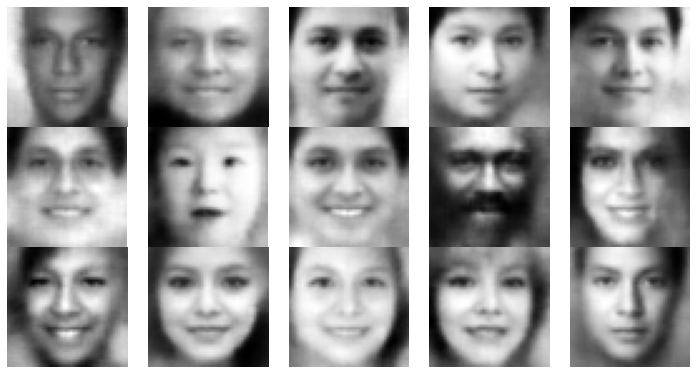

In [15]:
# show reconstructions
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(10, 5))
k=0
for i in range(3):
    for j in range(5):
        axes[i][j].imshow(samples[k], cmap='gray')
        axes[i][j].axis('off')
        k=k+1
plt.tight_layout(pad=0.)  

# Reconstruction

In [16]:
sample = next(iter(eval_dataloader))
sample_img = sample['image']

In [17]:
recons = VAE.generate(sample_img.to(device))

In [18]:
index = 0
original_img_1 = sample_img[index]
original_img_2 = sample_img[index+1]

(-0.5, 47.5, 47.5, -0.5)

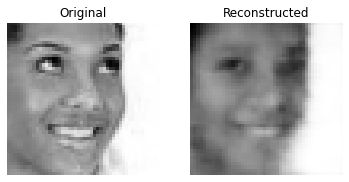

In [19]:
plt.subplot(121)
plt.imshow(np.squeeze(original_img_1), cmap='gray')
plt.title('Original')
plt.axis('off')

plt.subplot(122)
plt.imshow(np.squeeze(recons[index].detach().cpu().numpy()), cmap='gray')
plt.title('Reconstructed')
plt.axis('off')

(-0.5, 47.5, 47.5, -0.5)

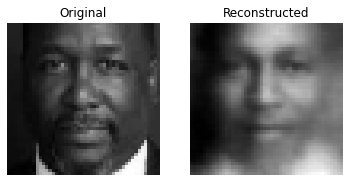

In [20]:
plt.subplot(121)
plt.imshow(np.squeeze(original_img_2), cmap='gray')
plt.title('Original')
plt.axis('off')

plt.subplot(122)
plt.imshow(np.squeeze(recons[index+1].detach().cpu().numpy()), cmap='gray')
plt.title('Reconstructed')
plt.axis('off')

# Interpolation

In [21]:
starting_inputs = original_img_1.unsqueeze(0)
ending_inputs = original_img_2.unsqueeze(0)

granularity = 10

interpolation = VAE.interpolate(starting_inputs=starting_inputs, ending_inputs=ending_inputs, device=device, granularity=granularity).squeeze()

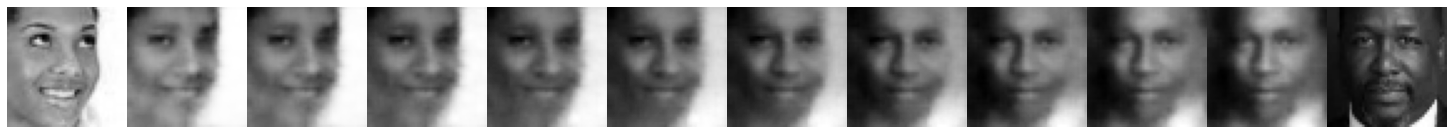

In [22]:
fig, axes = plt.subplots(nrows=1, ncols=granularity+2, figsize=(20, 5))

for j in range(granularity):
    axes[j+1].imshow(np.squeeze(interpolation[j].detach().cpu().numpy()), cmap='gray')
    axes[j+1].axis('off')
    
axes[0].imshow(np.squeeze(original_img_1), cmap='gray')
axes[0].axis('off')
axes[granularity+1].imshow(np.squeeze(original_img_2), cmap='gray')
axes[granularity+1].axis('off')  

plt.tight_layout(pad=0.)  

# Visualizing each component of the latent space

In [23]:
total_z = []

for train_sample in train_dataset:
    
    img = train_sample['image'].to(device)
    
    _, _, _, _, z = VAE.forward(img.unsqueeze(0))
    
    z = z.squeeze().detach().cpu().numpy()
    
    total_z.append(z)
    
total_z = np.array(total_z)

In [24]:
max_z = total_z.max(axis=0)
min_z = total_z.min(axis=0)

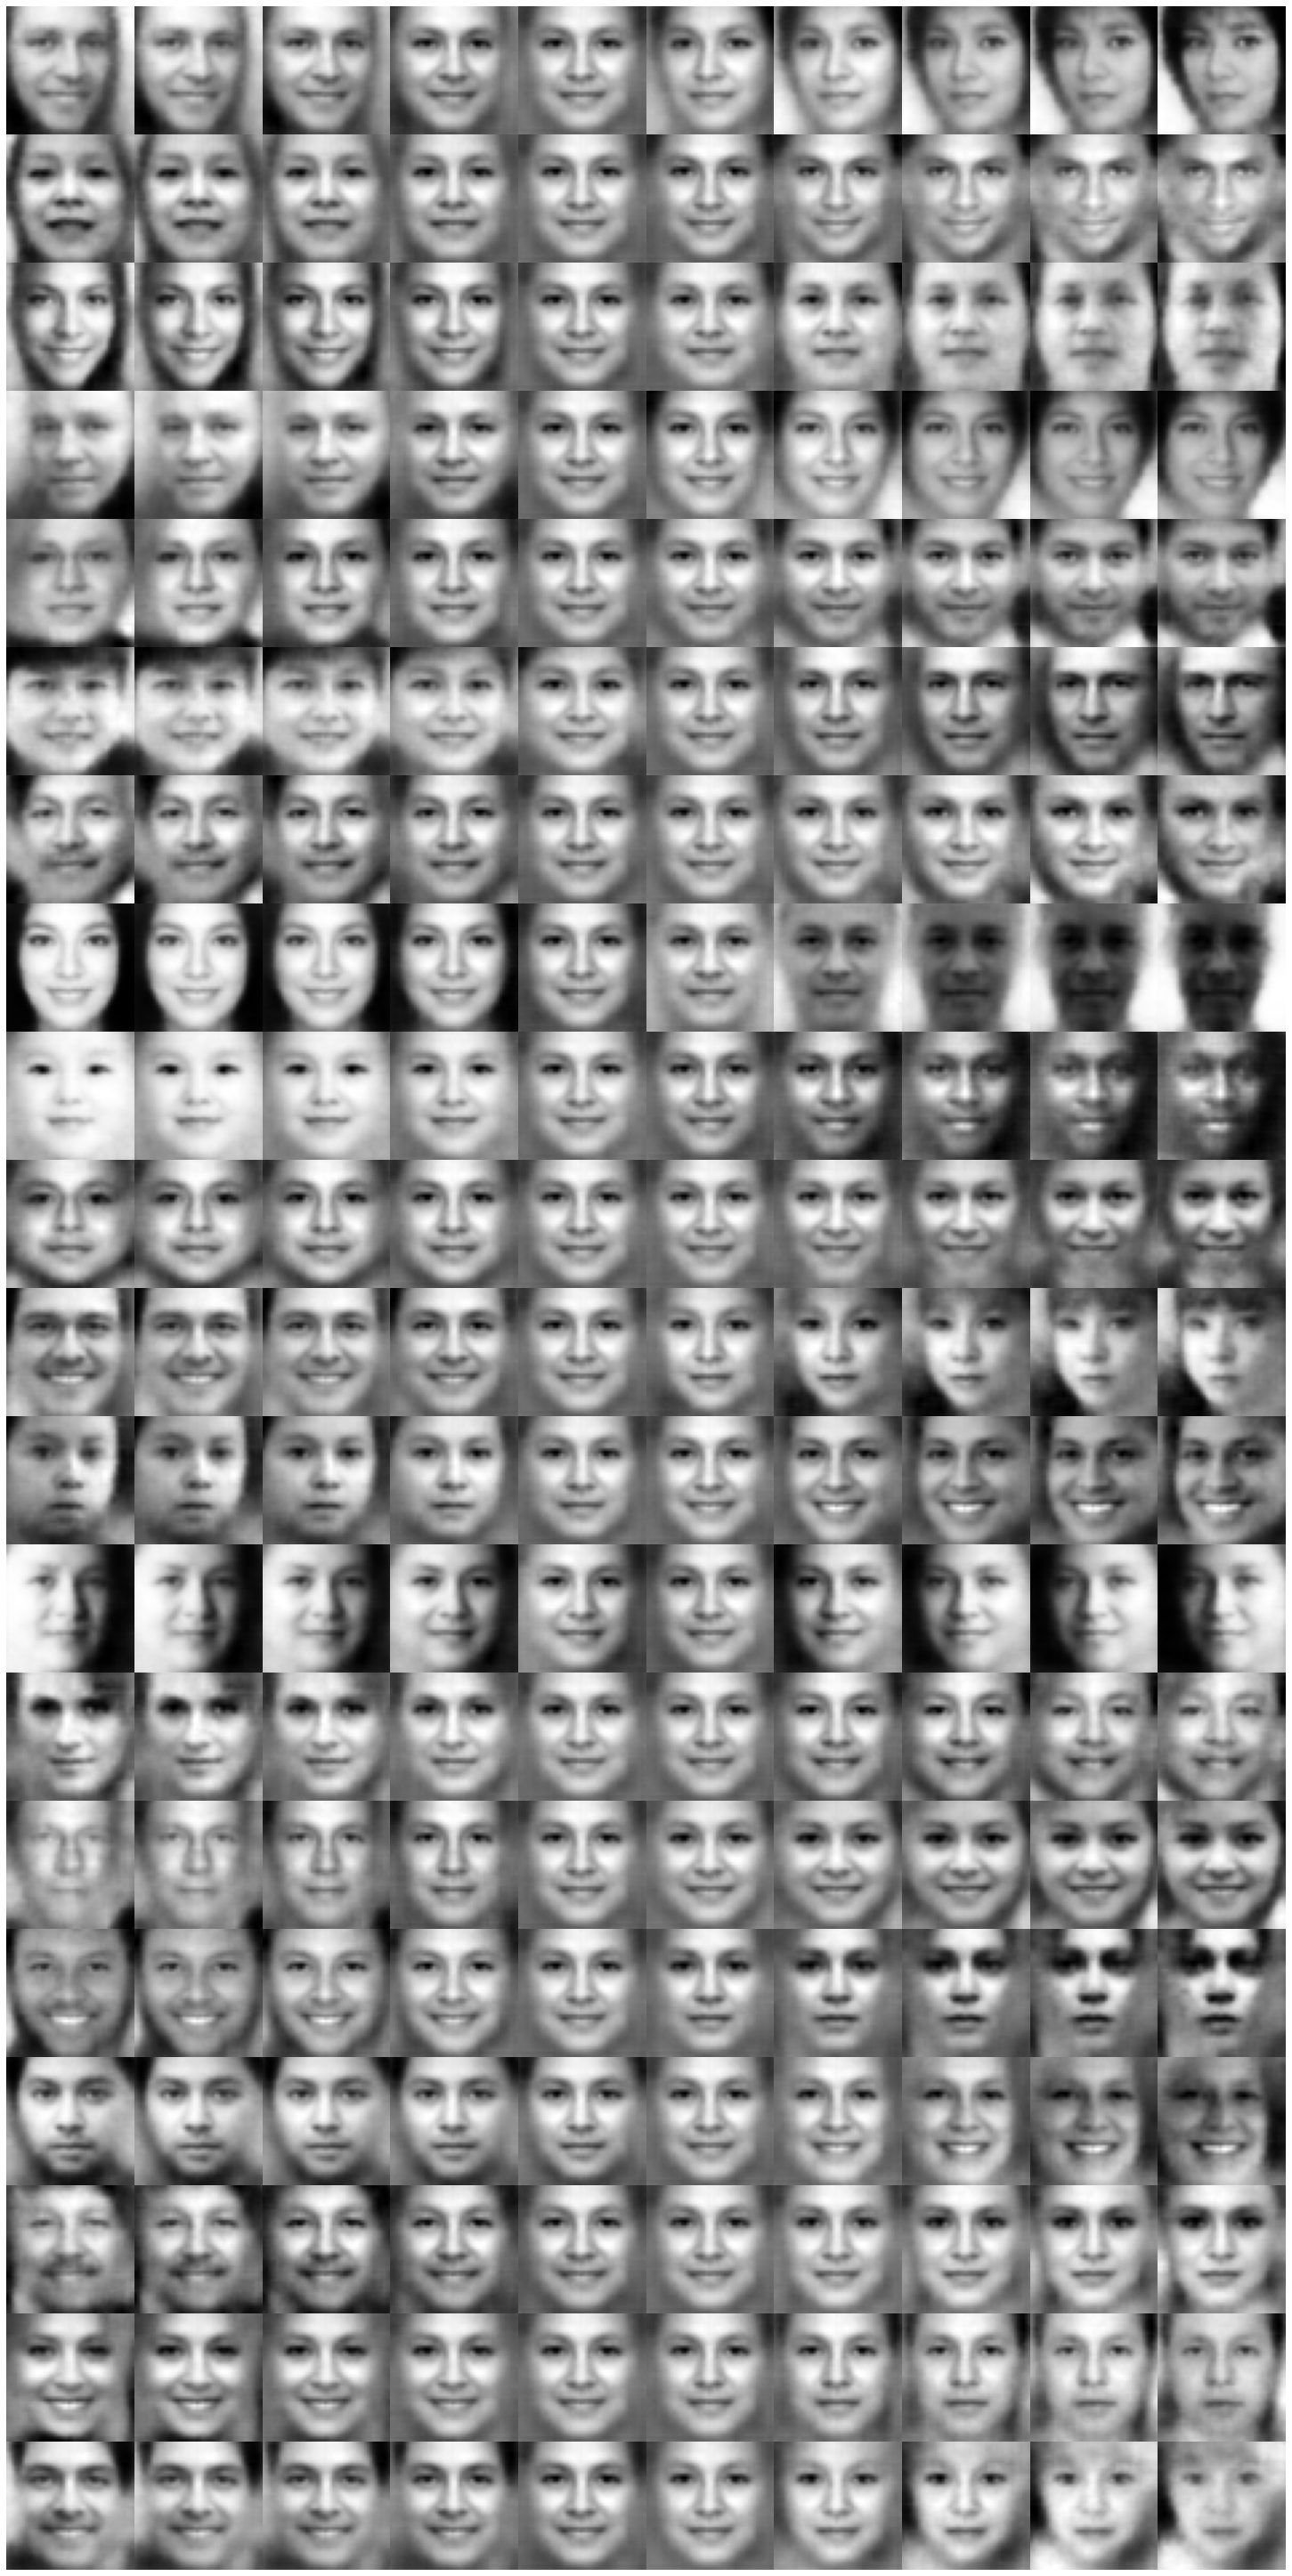

In [25]:
granularity = 10
latent_space_dims = VAE.get_latent_dims()

fig, axes = plt.subplots(nrows=latent_space_dims, ncols=granularity, figsize=(20, 40))

for i in range(latent_space_dims):
    
    t = torch.linspace(min_z[i], max_z[i], granularity).to(device)
    
    z = torch.zeros([1, latent_space_dims]).to(device)
    
    for j, y in enumerate(t):

        z[0][i] = y

        imgs_decoded = VAE.decode(z).squeeze()

        axes[i][j].imshow(imgs_decoded.detach().cpu().numpy(), cmap='gray')
        axes[i][j].axis('Off')

plt.tight_layout(pad=0.) 